# Gluon example with DALI

## Overview

This is a modified [DCGAN example](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html), which uses DALI for reading and augmenting images.

## Sample

In [1]:
import os.path
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

In [2]:
epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

In [3]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [4]:
target_wd = 64
target_ht = 64

In [5]:
from nvidia.dali import pipeline_def, Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import numpy as np


@pipeline_def
def gluon_pipe():
    jpegs, labels = fn.readers.file(
        name='Reader', file_root=data_path + '/lfw-deepfunneled/', random_shuffle = True, pad_last_batch=True)
    images = fn.decoders.image(jpegs, device='mixed')
    images = fn.resize(
        images, resize_x=target_wd, resize_y=target_ht, interp_type=types.INTERP_LINEAR)
    images = fn.rotate(images, angle=fn.random.uniform(range=(-10., 10)))
    images = fn.crop_mirror_normalize(
        images,
        dtype=types.FLOAT,
        crop=(target_wd, target_ht),
        mean=[127.5, 127.5, 127.5],
        std=[127.5, 127.5, 127.5])
    return images


In [6]:
pipe = gluon_pipe(batch_size=batch_size, num_threads=4, device_id=0)
pipe.build()

In [7]:
pipe_out = pipe.run()

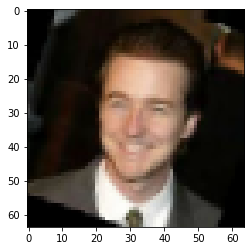

In [8]:
pipe_out_cpu = pipe_out[0].as_cpu()
img_chw = pipe_out_cpu.at(20)
%matplotlib inline
plt.imshow((np.transpose(img_chw, (1,2,0))+1.0)/2.0)

In [9]:
from nvidia.dali.plugin.mxnet import DALIGenericIterator, LastBatchPolicy
# recreate pipeline to avoid mixing simple with iterator API
pipe = gluon_pipe(batch_size=batch_size, num_threads=4, device_id=0)
pipe.build()
dali_iter = DALIGenericIterator(
    pipe,
    [("data", DALIGenericIterator.DATA_TAG)],
    reader_name="Reader",
    last_batch_policy=LastBatchPolicy.PARTIAL)

In [10]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [11]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [12]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    iter = 0
    for batches in dali_iter:  # Using DALI iterator
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batches[0].data[0]  # extracting the batch for device 0
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(data.shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(data.shape[0])

        # Print log infomation every ten batches
        if iter % 100 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()
    dali_iter.reset()

    name, acc = metric.get()
    metric.reset()

INFO:root:speed: 594.133498594542 samples/s
INFO:root:discriminator loss = 1.548318, generator loss = 6.110404, binary training acc = 0.554688 at iter 0 epoch 0
INFO:root:speed: 1864.6789758123898 samples/s
INFO:root:discriminator loss = 1.875944, generator loss = 10.167295, binary training acc = 0.884360 at iter 100 epoch 0
INFO:root:speed: 1925.027473197318 samples/s
INFO:root:discriminator loss = 1.383538, generator loss = 11.330649, binary training acc = 0.861046 at iter 200 epoch 0
INFO:root:speed: 1916.2053295452113 samples/s
INFO:root:discriminator loss = 0.729032, generator loss = 4.568172, binary training acc = 0.812500 at iter 0 epoch 1
INFO:root:speed: 1879.8790985615642 samples/s
INFO:root:discriminator loss = 0.659974, generator loss = 9.797787, binary training acc = 0.876702 at iter 100 epoch 1
INFO:root:speed: 1831.536308618137 samples/s
INFO:root:discriminator loss = 0.543448, generator loss = 8.295659, binary training acc = 0.876049 at iter 200 epoch 1
INFO:root:speed:

In [13]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matp

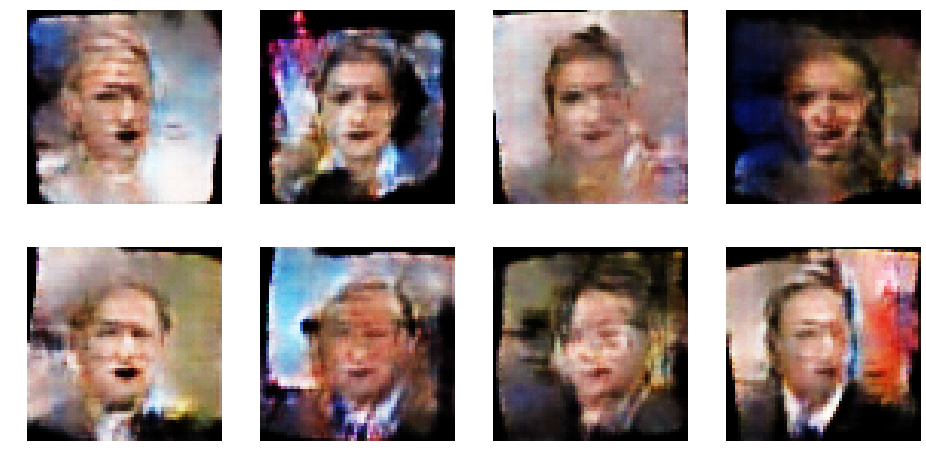

In [14]:
num_image = 8
fig = plt.figure(figsize = (16,8))
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()